In [1]:
# Imports (safe to re-run even if executed earlier)
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

# Paths
THIS_DIR   = Path.cwd()          # assume we're still inside visualization/
ROOT_DIR   = THIS_DIR.parent
RESULTS_DIR = ROOT_DIR / "results"

FIG_DIR = THIS_DIR / "figures" / "unet_vs_resnet_fno"
FIG_DIR.mkdir(parents=True, exist_ok=True)

# Model map for this comparison
MODELS = {
    "Best UNet": "best_unet",
    "ResNet"   : "resnet",
    "FNO"      : "fno",
}

print("Figures will be saved to →", FIG_DIR.relative_to(ROOT_DIR))


Figures will be saved to → visualization/figures/unet_vs_resnet_fno


In [2]:
def load_metrics(folder_name: str) -> pd.DataFrame:
    csv_path = RESULTS_DIR / folder_name / "metrics.csv"
    if not csv_path.exists():
        raise FileNotFoundError(csv_path)
    return pd.read_csv(csv_path)

def get_val_row(df: pd.DataFrame) -> pd.Series:
    numeric_mask = pd.to_numeric(df["epoch"], errors="coerce").notna()
    return df[numeric_mask].iloc[-1]

def get_test_row(df: pd.DataFrame) -> pd.Series:
    if (df["epoch"] == "test").any():
        return df[df["epoch"] == "test"].iloc[0]
    return df.iloc[-1]

# --- read each CSV once ---
RAW_LOGS  = {k: load_metrics(v) for k, v in MODELS.items()}
VAL_ROWS  = {k: get_val_row(df) for k, df in RAW_LOGS.items()}
TEST_ROWS = {k: get_test_row(df) for k, df in RAW_LOGS.items()}

pd.DataFrame({
    "test/tas/rmse": [TEST_ROWS[k]["test/tas/rmse"] for k in MODELS],
    "val/tas/rmse":  [VAL_ROWS[k]["val/tas/rmse"]   for k in MODELS],
}, index=list(MODELS))


,test/tas/rmse,val/tas/rmse
Best UNet,291.104980,1.914860
ResNet,290.133026,4.572353
FNO,290.942108,2.545542


Saved → visualization/figures/unet_vs_resnet_fno/bar_final_test_rmse.png


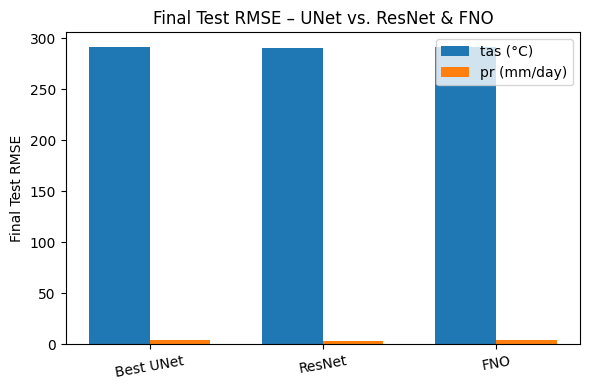

In [3]:
labels        = list(MODELS.keys())
tas_test_rmse = [TEST_ROWS[l]["test/tas/rmse"] for l in labels]
pr_test_rmse  = [TEST_ROWS[l]["test/pr/rmse"]  for l in labels]

x = range(len(labels)); w = 0.35
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar([i - w/2 for i in x], tas_test_rmse, width=w, label="tas (°C)")
ax.bar([i + w/2 for i in x], pr_test_rmse,  width=w, label="pr (mm/day)")

ax.set_xticks(x); ax.set_xticklabels(labels, rotation=10)
ax.set_ylabel("Final Test RMSE")
ax.set_title("Final Test RMSE – UNet vs. ResNet & FNO")
ax.legend(); fig.tight_layout()

save_path = FIG_DIR / "bar_final_test_rmse.png"
fig.savefig(save_path, dpi=300); print("Saved →", save_path.relative_to(ROOT_DIR))
plt.show()


/tmp/ipykernel_41286/682946386.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


Saved → visualization/figures/unet_vs_resnet_fno/line_val_rmse_vs_epoch.png


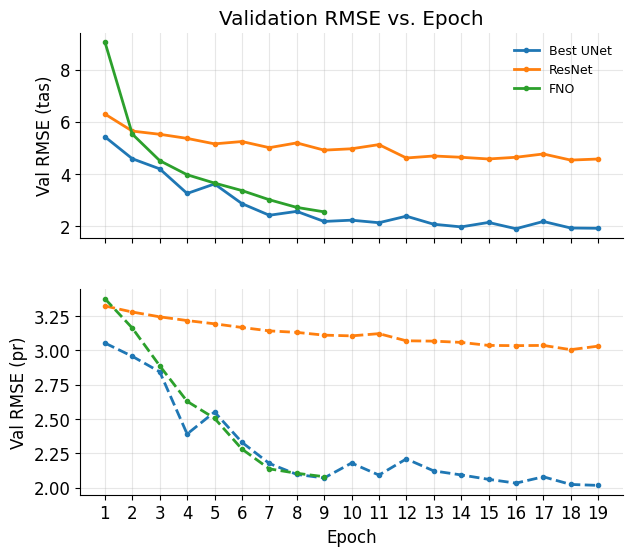

In [4]:
mpl.rcParams.update({
    "axes.spines.top": False, "axes.spines.right": False,
    "axes.grid": True, "grid.alpha": 0.3,
    "lines.linewidth": 2.0, "font.size": 12,
})

fig, (ax_tas, ax_pr) = plt.subplots(2, 1, figsize=(7, 6), sharex=True,
                                    gridspec_kw={"hspace": 0.25})
cmap  = mpl.colormaps["tab10"]
ms = 3  # small markers
for idx, (label, df) in enumerate(RAW_LOGS.items()):
    color = cmap(idx)
    # Solid line for tas
    ax_tas.plot(df["epoch"], df["val/tas/rmse"],
                color=color, label=label,
                marker="o", markersize=ms, markevery=1)
    # Dashed line for pr
    ax_pr.plot(df["epoch"], df["val/pr/rmse"],
               color=color, linestyle="--", label=label,
               marker="o", markersize=ms, markevery=1)

ax_tas.set_ylabel("Val RMSE (tas)")
ax_tas.set_title("Validation RMSE vs. Epoch")
ax_tas.legend(frameon=False, fontsize=9)

ax_pr.set_ylabel("Val RMSE (pr)")
ax_pr.set_xlabel("Epoch")

fig.tight_layout()
save_path = FIG_DIR / "line_val_rmse_vs_epoch.png"
fig.savefig(save_path, dpi=300); print("Saved →", save_path.relative_to(ROOT_DIR))
plt.show()


Saved → visualization/figures/unet_vs_resnet_fno/line_convergence_train_val_loss.png


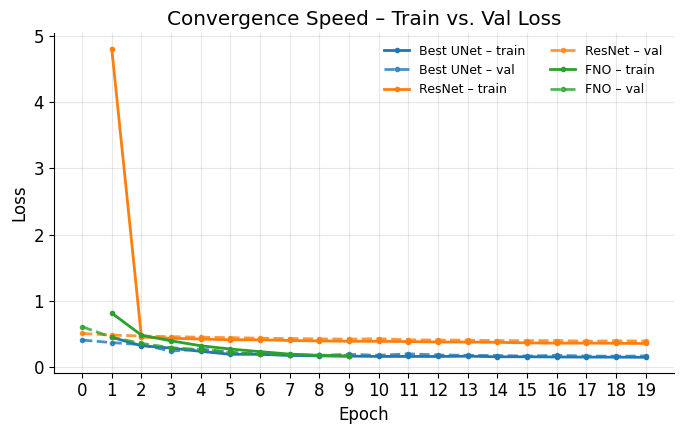

In [5]:
fig, ax = plt.subplots(figsize=(7, 4.5))
for idx, (label, df) in enumerate(RAW_LOGS.items()):
    color = cmap(idx)
    ax.plot(df["epoch"], df["train/loss_epoch"], color=color,
            label=f"{label} – train", marker="o", markevery=1, markersize=ms)
    ax.plot(df["epoch"], df["val/loss"], linestyle="--", color=color, alpha=0.8,
            label=f"{label} – val", marker="o", markevery=1, markersize=ms)

ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Convergence Speed – Train vs. Val Loss")
ax.legend(ncol=2, fontsize=9, frameon=False)
fig.tight_layout()

save_path = FIG_DIR / "line_convergence_train_val_loss.png"
fig.savefig(save_path, dpi=300); print("Saved →", save_path.relative_to(ROOT_DIR))
plt.show()


Saved → visualization/figures/unet_vs_resnet_fno/bar_relative_improvement.png


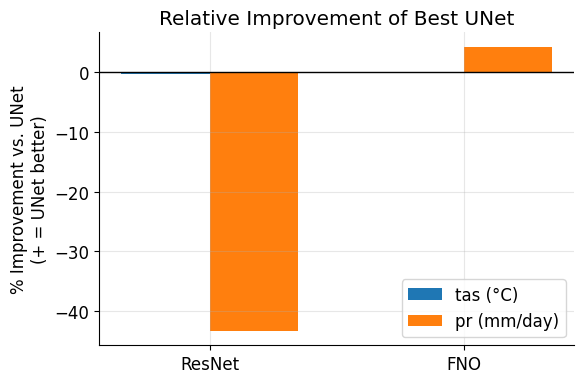

In [6]:
# % improvement: positive number = UNet better (lower RMSE)
def rel_improve(best, other):
    return 100 * (other - best) / other

tas_improve = [rel_improve(TEST_ROWS["Best UNet"]["test/tas/rmse"], 
                           TEST_ROWS[m]["test/tas/rmse"])
               for m in ("ResNet", "FNO")]
pr_improve  = [rel_improve(TEST_ROWS["Best UNet"]["test/pr/rmse"], 
                           TEST_ROWS[m]["test/pr/rmse"])
               for m in ("ResNet", "FNO")]

x = range(len(tas_improve)); w = 0.35
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar([i - w/2 for i in x], tas_improve, width=w, label="tas (°C)")
ax.bar([i + w/2 for i in x], pr_improve,  width=w, label="pr (mm/day)")

ax.set_xticks(x); ax.set_xticklabels(["ResNet", "FNO"])
ax.set_ylabel("% Improvement vs. UNet\n(+ = UNet better)")
ax.set_title("Relative Improvement of Best UNet")
ax.axhline(0, color="k", linewidth=1)
ax.legend(); fig.tight_layout()

save_path = FIG_DIR / "bar_relative_improvement.png"
fig.savefig(save_path, dpi=300); print("Saved →", save_path.relative_to(ROOT_DIR))
plt.show()


In [7]:
print("Saved figures:")
for p in sorted(FIG_DIR.glob("*.png")):
    print(" •", p.relative_to(ROOT_DIR))


Saved figures:
 • visualization/figures/unet_vs_resnet_fno/bar_final_test_rmse.png
 • visualization/figures/unet_vs_resnet_fno/bar_relative_improvement.png
 • visualization/figures/unet_vs_resnet_fno/line_convergence_train_val_loss.png
 • visualization/figures/unet_vs_resnet_fno/line_val_rmse_vs_epoch.png
